In [226]:

import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import fsolve

LAMBDA = 0 # Random number for now

class Component:
    def __init__(self, name, residence_time):
        self.name = name
        self.residence_time = residence_time
        self.input_ports = {}  # Dictionary where the key is the port name and the value is the port object
        self.output_ports = {}  # Dictionary where the key is the port name and the value is the port object
        self.tritium_inventory = 0
        # self.equation = 0

    def add_input_port(self, port_name, incoming_fraction=1.0):
        if not (0 <= incoming_fraction <= 1):
            raise ValueError("Incoming fraction must be between 0 and 1")
        port = Port(port_name)
        port.incoming_fraction = incoming_fraction
        self.input_ports[port_name] = port
        return port

    def add_output_port(self, port_name):
        port = Port(port_name)
        self.output_ports[port_name] = port
        return port

    def __str__(self):
        return f"{self.name}: Residence Time = {self.residence_time}, Tritium Inventory = {self.tritium_inventory}"

    def add_tritium(self, amount):
        self.tritium_inventory += amount

    def remove_tritium(self, amount):
        if self.tritium_inventory >= amount:
            self.tritium_inventory -= amount
            return amount
        else:
            removed_amount = self.tritium_inventory
            self.tritium_inventory = 0
            return removed_amount
        
    def get_inflow(self):
        inflow = 0
        for port in self.input_ports.values():
            inflow += port.flow_rate
        return inflow   
        
    def get_outflow(self):
        return self.tritium_inventory / self.residence_time
    
    def calculate_inventory_derivative(self):
        inflow = self.get_inflow()
        outflow = self.get_outflow()
        decay = self.tritium_inventory * LAMBDA  # assuming decay_rate is a constant
        dydt = inflow - outflow - decay
        return dydt
    

class Port:
    def __init__(self, name, incoming_fraction=1.0):
        self.name = name
        self.flow_rate = 0
        self.incoming_fraction = incoming_fraction
        
    def set_flow_rate(self, flow_rate):
        self.flow_rate = flow_rate
    
class ComponentMap:
    def __init__(self):
        self.components = {}
        self.connections = {}

    def add_component(self, component):
        self.components[component.name] = component

    def connect_ports(self, component1, port1, component2, port2):
        if component1.name not in self.connections:
            self.connections[component1.name] = {}
        if component2.name not in self.connections:
            self.connections[component2.name] = {}

        self.connections[component1.name][port1.name] = (component2.name, port2.name)
        self.connections[component2.name][port2.name] = (component1.name, port1.name)
        if port1 and port2:
                port1.set_flow_rate(component1.get_outflow())
                port2.set_flow_rate(component1.get_outflow() * port2.incoming_fraction)

    def disconnect_ports(self, component1, port1, component2, port2):
        if component1.name in self.connections and port1.name in self.connections[component1.name]:
            del self.connections[component1.name][port1.name]
        if component2.name in self.connections and port2.name in self.connections[component2.name]:
            del self.connections[component2.name][port2.name]

    def get_connected_ports(self, component, port):
        if component.name in self.connections and port.name in self.connections[component.name]:
            connected_component_name, connected_port_name = self.connections[component.name][port.name]
            connected_component = self.components[connected_component_name]
            connected_port = connected_component.input_ports[connected_port_name]
            return connected_component, connected_port
        else:
            return None, None
        
    def print_connected_map(self):
        for component_name, ports in self.connections.items():
            print(f"Component: {component_name}")
            for port_name, (connected_component_name, connected_port_name) in ports.items():
                print(f"  Port: {port_name} -> Connected Component: {connected_component_name}, Connected Port: {connected_port_name}")

class Simulate:
    def __init__(self, dt, final_time, components):
        self.dt = dt
        self.final_time = final_time
        self.time = []
        self.n_steps = int(final_time / dt)
        self.initial_conditions = [component.tritium_inventory for component in components.values()]
        self.y = np.zeros((self.n_steps + 1, len(self.initial_conditions)))
        self.components = components

    # @classmethod
    # def run_simulation(cls, components, timesteps):
    #     # Simulate inventory evolution for each component
    #     inventory_evolution_data = {}
    #     for component_name, component in components.items():
    #         time, inventory_evolution = component.simulate_inventory_evolution(timesteps)
    #         inventory_evolution_data[component_name] = {'time': time, 'inventory': inventory_evolution}
    #     return inventory_evolution_data

    def forward_euler(self):
        self.y[0] = self.initial_conditions
        for n in range(self.n_steps):
            t = n * self.dt
            dydt = self.f(self.y[n])
            self.y[n+1] = self.y[n] + self.dt * dydt
            self.time.append(t)
        return [self.time, self.y[:-1,:]]
    
    def f(self, y):
        dydt = np.zeros_like(y)
        for i, component in enumerate(self.components.values()):
            dydt[i] += component.calculate_inventory_derivative()
        return dydt 

In [240]:
def visualize_connections(component_map):
    # Create a directed graph
    G = nx.DiGraph()

    # Add nodes for each component
    for component in component_map.components.values():
        G.add_node(component.name)

    # Add edges for each connection
    for component_name, ports in component_map.connections.items():
        for port_name, (connected_component_name, _) in ports.items():
            if port_name in component_map.components[component_name].output_ports:
                G.add_edge(component_name, connected_component_name)

    # Draw the graph
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=10, edge_color='gray', arrows=True)

    # Show the plot
    plt.show()


Component: Storage
  Port: Port 1 -> Connected Component: OFC, Connected Port: Port 2
  Port: Port 6 -> Connected Component: IFC, Connected Port: Port 5
Component: OFC
  Port: Port 2 -> Connected Component: Storage, Connected Port: Port 1
  Port: Port 3 -> Connected Component: IFC, Connected Port: Port 4
Component: IFC
  Port: Port 4 -> Connected Component: OFC, Connected Port: Port 3
  Port: Port 5 -> Connected Component: Storage, Connected Port: Port 6


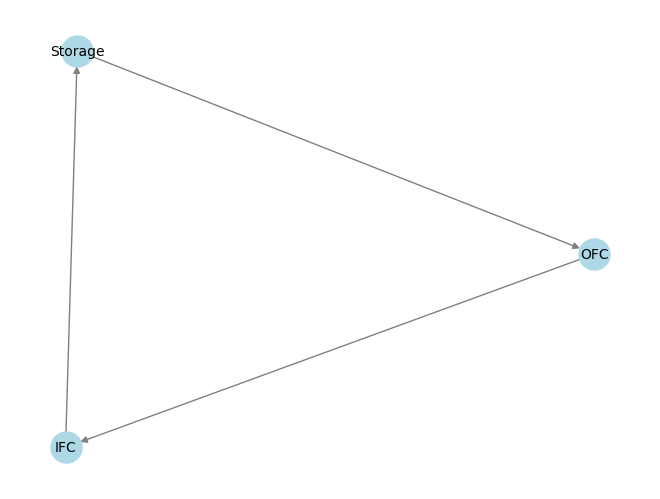

In [246]:
component1 = Component("Storage", 1000)
component2 = Component("OFC", 10)
component3 = Component("IFC", 10)
component1.tritium_inventory = 10
component2.tritium_inventory = 3
port1 = component1.add_output_port("Port 1")
port2 = component2.add_input_port("Port 2")
port3 = component2.add_output_port("Port 3")
port4 = component3.add_input_port("Port 4")
port5 = component3.add_output_port("Port 5")
port6 = component1.add_input_port("Port 6")

component_map = ComponentMap()
component_map.add_component(component1)
component_map.add_component(component2)
component_map.add_component(component3)
component_map.connect_ports(component1, port1, component2, port2)
component_map.connect_ports(component2, port3, component3, port4)
component_map.connect_ports(component3, port5, component1, port6)
component_map.print_connected_map()
visualize_connections(component_map)

[  9.001 -25.971  29.97 ]


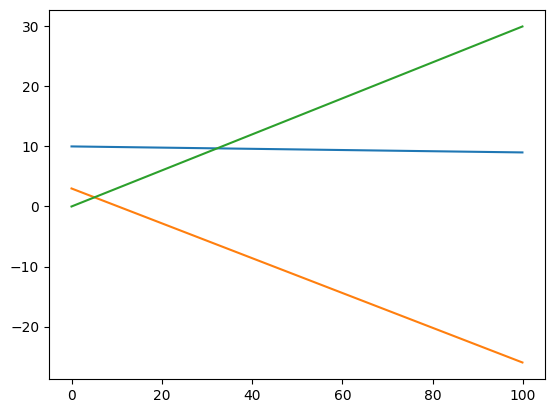

In [245]:
components = component_map.components
simulation = Simulate(0.1, 100, components)
t,y = simulation.forward_euler()
plt.plot(t, y)
print(y[-1,:])

In [6]:
# Create the components
component1 = Component("Component 1", 5)
component2 = Component("Component 2", 3)
component3 = Component("Component 3", 4)
# component4 = Component("Component 4", 6)
# component5 = Component("Component 5", 2)

# # Create the ports
port1 = component1.add_output_port("Port 1")
port2 = component2.add_input_port("Port 2")
port3 = component2.add_output_port("Port 3")
port4 = component3.add_input_port("Port 4")
# port5 = component3.add_output_port("Port 5")
# port6 = component4.add_input_port("Port 6")
# port7 = component4.add_output_port("Port 7")
# port8 = component5.add_input_port("Port 8")
# port9 = component5.add_output_port("Port 9")  # Additional port between Component 3 and Component 5
# port10 = component5.add_output_port("Port 10")  # Additional port for Component 5
# port11 = component1.add_input_port("Port 11")  # Additional port for Component 1

# # Connect the ports
# component_map = ComponentMap()
# component_map.connect_ports(component1, port1, component2, port2)
# component_map.connect_ports(component2, port3, component3, port4)
# component_map.connect_ports(component3, port5, component4, port6)
# component_map.connect_ports(component4, port7, component5, port8)
# component_map.connect_ports(component5, port9, component3, port5)  # Connect the additional port
# component_map.connect_ports(component5, port10, component1, port11)  # Connect the additional port
# Example usage:
# ... add components and connections to the component_map ...
# visualize_connections(component_map)

